##### TP integrador
Download Dataset here:
[Buenos Aires public bike system](https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download)



In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from scipy.optimize import curve_fit



In [69]:
HTML('<a href="https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download" target="_blank">Download Dataset</a>')

In [3]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
len(df)

1457509

In [4]:
df.head(2)
#df.info()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais
0,15728,26/05/2018 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina
1,26531,26/05/2018 3:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina


In [5]:
# Convertir fecha_hora_retiro a datetime

df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))


Text(0.5, 1.0, 'Alquiler de bicis Julio 2016 - Julio 2018')

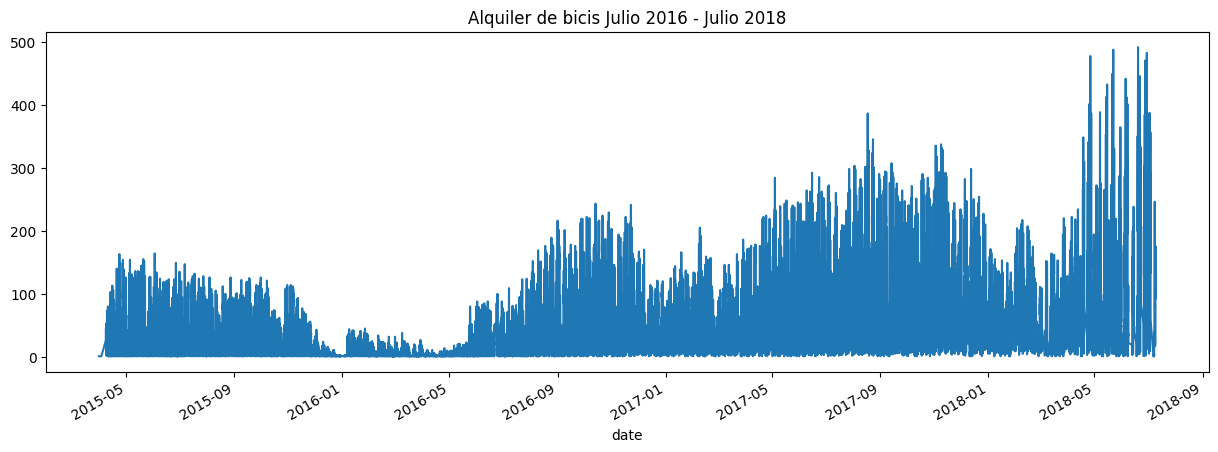

In [6]:
plt.figure(figsize=(15,5))
df.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Julio 2016 - Julio 2018')

#### Limpieza de datos

Observamos que hay muchos menos registros durante los primeros meses de 2016. Es por esta razón que tomaremos la decisión de achicar la serie y quedarnos con dos años de datos, desde Julio 2016 a 2018.

In [38]:
fecha_limite = pd.to_datetime('2016-08-01 00:00:00')
df_shorten = df[df['date'] >= fecha_limite]
bicis_por_dia = df_shorten.groupby('date').bici_id_usuario.count()

Text(0.5, 1.0, 'Alquiler de bicis Agosto 2016 - Julio 2018')

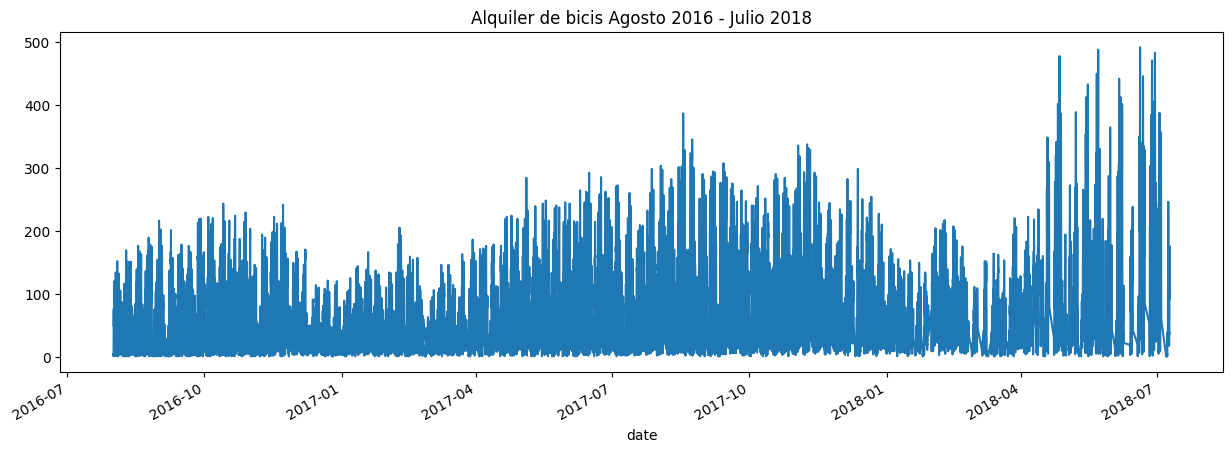

In [59]:
plt.figure(figsize=(15,5))
df_shorten.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Agosto 2016 - Julio 2018')

In [39]:
# Obtengo minutos de alquiler de bici

parse_duration = lambda duration_str: timedelta(
    hours=int(duration_str.split(':')[0]),
    minutes=int(duration_str.split(':')[1]) if len(duration_str.split(':')) >=2 else 0,
    seconds=int(duration_str.split(':')[2]) if len(duration_str.split(':')) >=3 else 0
)

df_shorten['bici_tiempo_uso_delta'] = df_shorten['bici_tiempo_uso'].apply(lambda x: parse_duration(x))
df_shorten['total_minutes'] = df_shorten['bici_tiempo_uso_delta'].dt.total_seconds() / 60

/var/folders/30/4fg_jqmn6t5bqy5p8vdxjmpr0000gp/T/ipykernel_907/4194004386.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shorten['bici_tiempo_uso_delta'] = df_shorten['bici_tiempo_uso'].apply(lambda x: parse_duration(x))
/var/folders/30/4fg_jqmn6t5bqy5p8vdxjmpr0000gp/T/ipykernel_907/4194004386.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shorten['total_minutes'] = df_shorten['bici_tiempo_uso_delta'].dt.total_seconds() / 60


In [40]:
min(df_shorten.total_minutes), max(df_shorten.total_minutes)

(8.0, 1756.9166666666667)

Text(0.5, 1.0, 'Boxplot: duración de alquiler de bici (excluyendo outliers)')

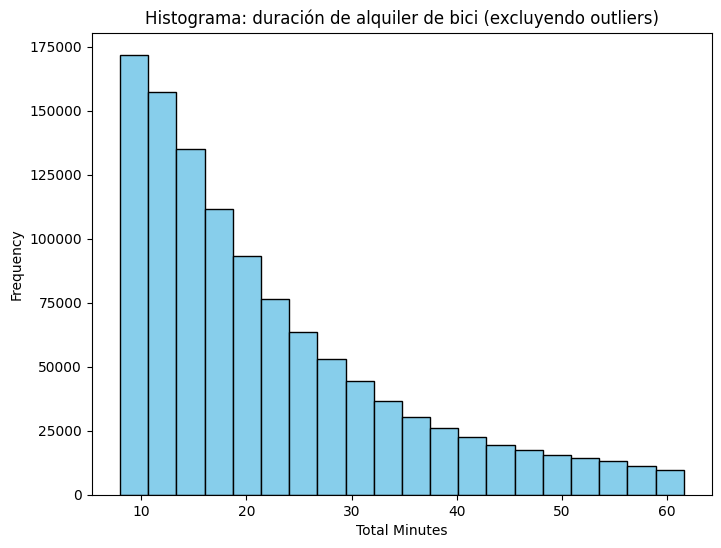

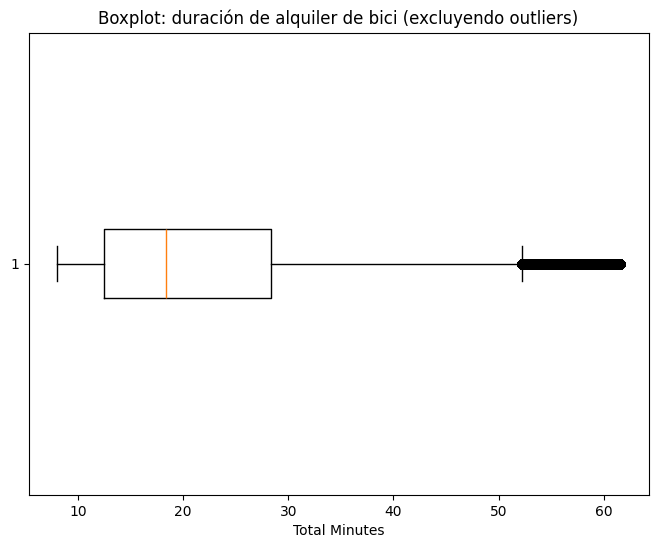

In [41]:
# Calculo quantiles
Q1 = df_shorten['total_minutes'].quantile(0.25)
Q3 = df_shorten['total_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtramos outliers
filtered_df = df_shorten[(df_shorten['total_minutes'] >= lower_bound) & (df_shorten['total_minutes'] <= upper_bound)]

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['total_minutes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.title('Histograma: duración de alquiler de bici (excluyendo outliers)')

plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['total_minutes'], vert=False)
plt.xlabel('Total Minutes')
plt.title('Boxplot: duración de alquiler de bici (excluyendo outliers)')


In [42]:
s = df_shorten.groupby('date').bici_id_usuario.count()

In [43]:
df_shorten.head()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais,date,bici_tiempo_uso_delta,total_minutes
0,15728,2018-05-26 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina,2018-05-26 15:00:00,0 days 00:08:52,8.866667
1,26531,2018-05-26 03:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina,2018-05-26 03:00:00,0 days 00:30:49,30.816667
2,161323,2018-05-26 18:52:19,0:12:00,Aime Paine,151,Retiro II,130,M,44.0,olga cossettini,NaN,2018-05-26 18:00:00,0 days 00:12:00,12.000000
3,239148,2018-05-26 13:19:34,1:26:30,Galerías Pacífico,34,Juana Manso,26,M,36.0,larrea,NaN,2018-05-26 13:00:00,0 days 01:26:30,86.500000
4,260323,2018-05-26 08:41:53,0:11:29,Virrey Cevallos,183,Corrientes,132,M,26.0,chacabuco,NaN,2018-05-26 08:00:00,0 days 00:11:29,11.483333


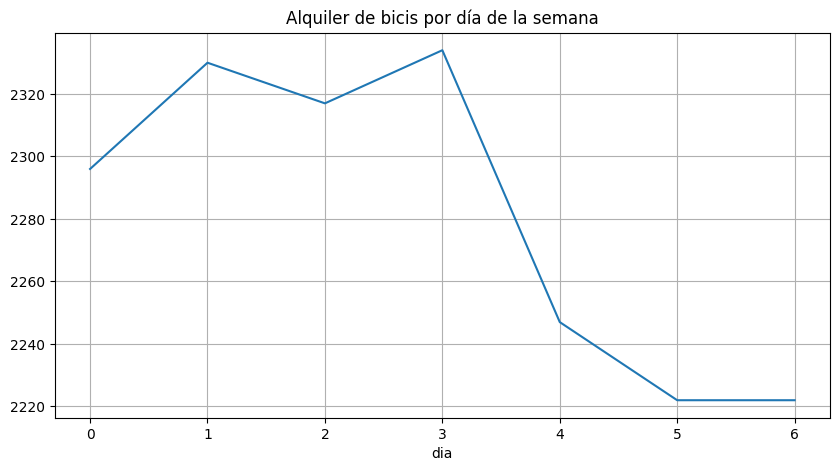

In [44]:
# Visualización por día de la semana

plt.figure(figsize=(10,5))
a = s.reset_index()
a['dia'] = a.date.apply(lambda x: x.weekday())
a.groupby('dia').bici_id_usuario.count().plot()
plt.xticks(list(range(7)))
plt.title('Alquiler de bicis por día de la semana')
plt.grid()


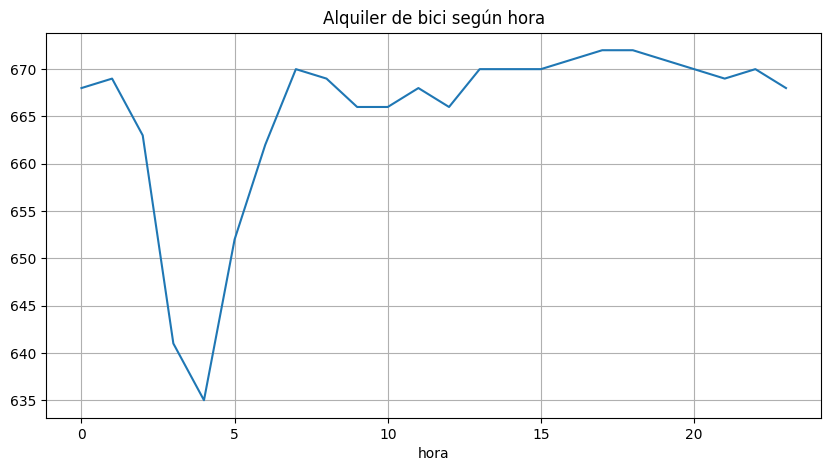

In [45]:
plt.figure(figsize=(10,5))
a['hora'] = a.date.apply(lambda x: x.hour)
a.groupby('hora').bici_id_usuario.count().plot()
plt.xticks()
plt.title('Alquiler de bici según hora')
plt.grid()


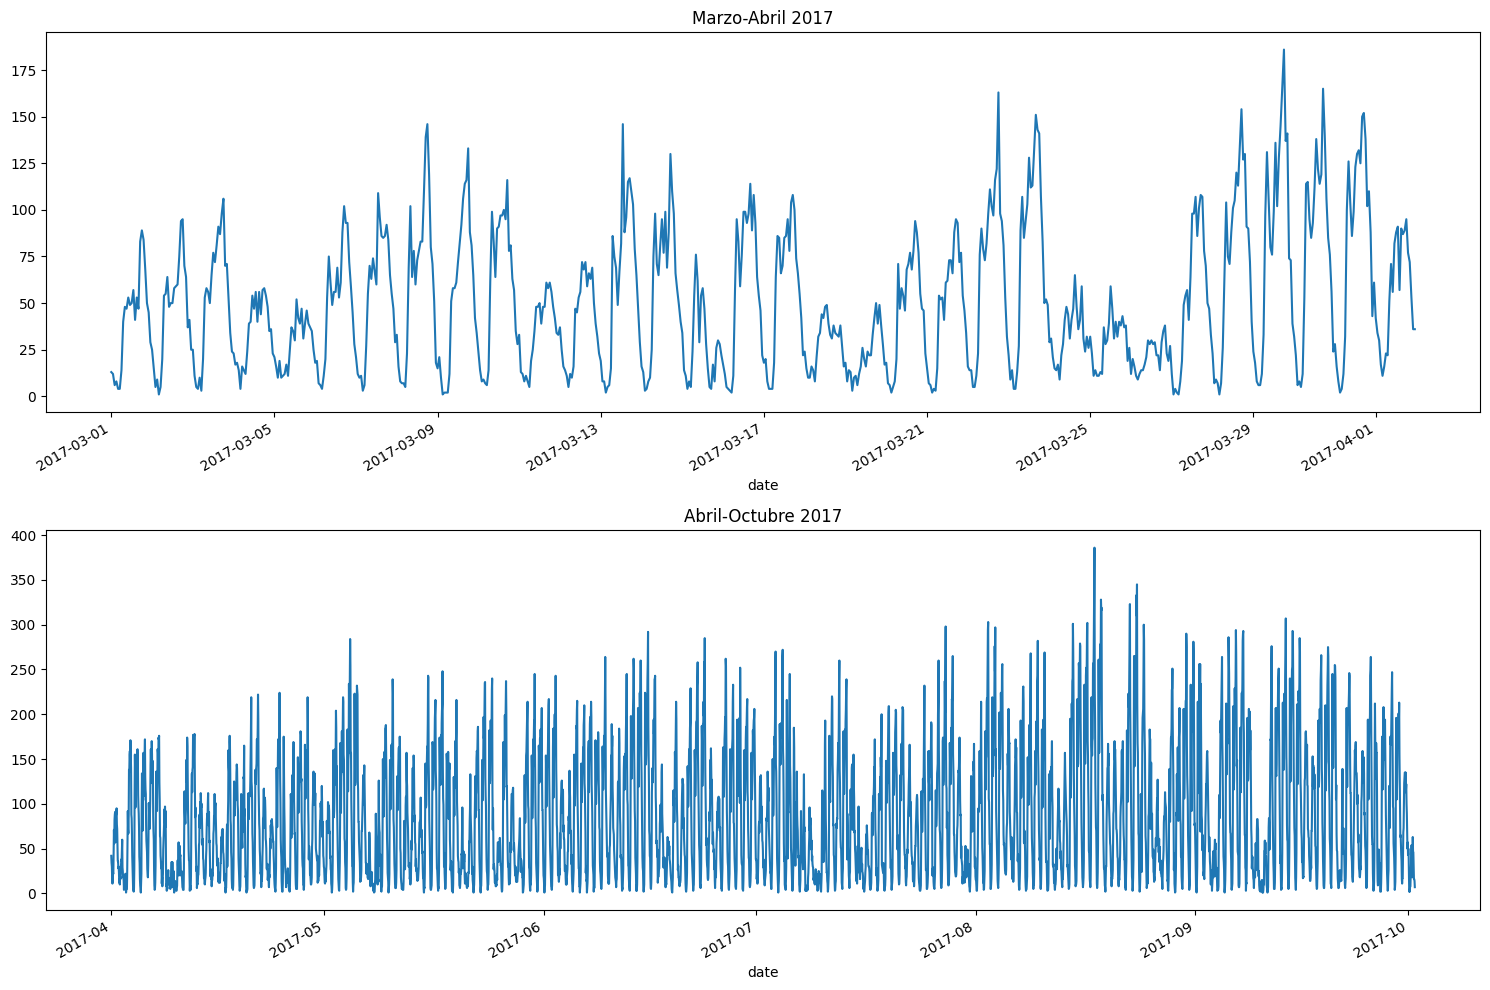

In [46]:
s = df.groupby('date').bici_id_usuario.count()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

## Visualización un mes de datos
s['2017-03-01': '2017-04-01'].plot(ax=axes[0])
axes[0].set_title('Marzo-Abril 2017')

# Visualización 6 meses de datos
s['2017-04-01': '2017-10-01'].plot(ax=axes[1])
axes[1].set_title('Abril-Octubre 2017')

plt.tight_layout()
plt.show()

#### Análisis
El dataset contiene información sobre el alquiler de bicicletas en la Ciudad de Buenos Aires durante el período Marzo 2015 - Julio 2018.

* En el gráfico de toda la serie se observa una tendencia alcista a partir del 2016 con dos valles marcados durante los meses de enero y febrero de 2017 y 2018 que coinciden con los meses donde la mayor cantidad de gente suele estar de vacaciones. 
La tendencia alcista parece deberse a un incremento en la adopción del servicio de alquiler de bicis.
* Se trata de una serie univariada y discreta 
* Graficamos también por día de la semana y por hora. Se observa cómo decae el alquiler durante los fines de semana y cómo la mayor cantidad de alquileres se da entre las 08 y las 20 horas, con un pico a la 18/19. Esto coincide con el horario en que la gente entra y sale de trabajar. Mientras que el alquiler cae drásticamente durante las horas de la madrugada.
* Graficando un mes de datos podemos observar cierta estacionalidad dada por los picos y valles entre semanas. 
* Graficando seis meses de datos en el período de Abril 2017 - Octubre 2017 vemos que la estacionalidad se mantiene.

#### Modelo aditivo de cuatro componentes: seasonal, tendencia, ciclica, error

In [47]:
daily_rentals = df_shorten.groupby(pd.Grouper(key='date', freq='D'))['total_minutes'].median().reset_index()

In [48]:
dr = daily_rentals.set_index('date')

In [49]:
dr.total_minutes.head()

date
2016-08-01    18.000000
2016-08-02    19.750000
2016-08-03    18.566667
2016-08-04    19.416667
2016-08-05    18.025000
Name: total_minutes, dtype: float64

<Axes: xlabel='date'>

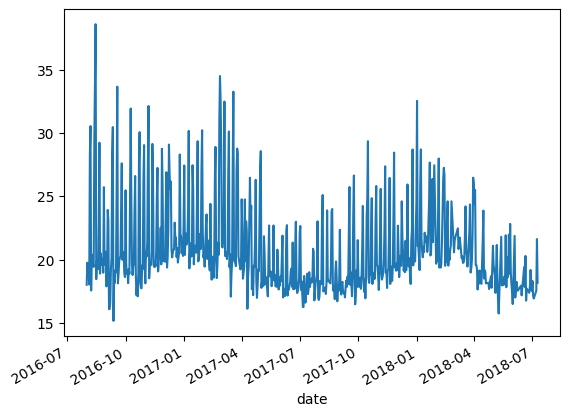

In [50]:
dr.total_minutes.dropna().plot()


In [51]:
dr = dr.dropna()
dr = dr[dr.total_minutes < 1000]

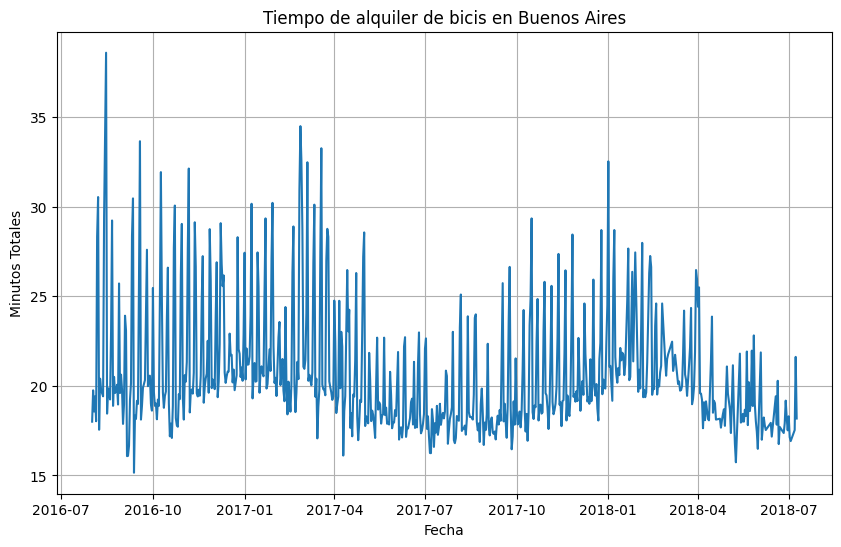

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(dr.index, dr['total_minutes'])
plt.title('Tiempo de alquiler de bicis en Buenos Aires')
plt.xlabel('Fecha')
plt.ylabel('Minutos Totales')
plt.grid(True)

In [53]:

daily_rent = df_shorten.set_index('date')
daily_rent = daily_rent.resample('D').bici_id_usuario.count()


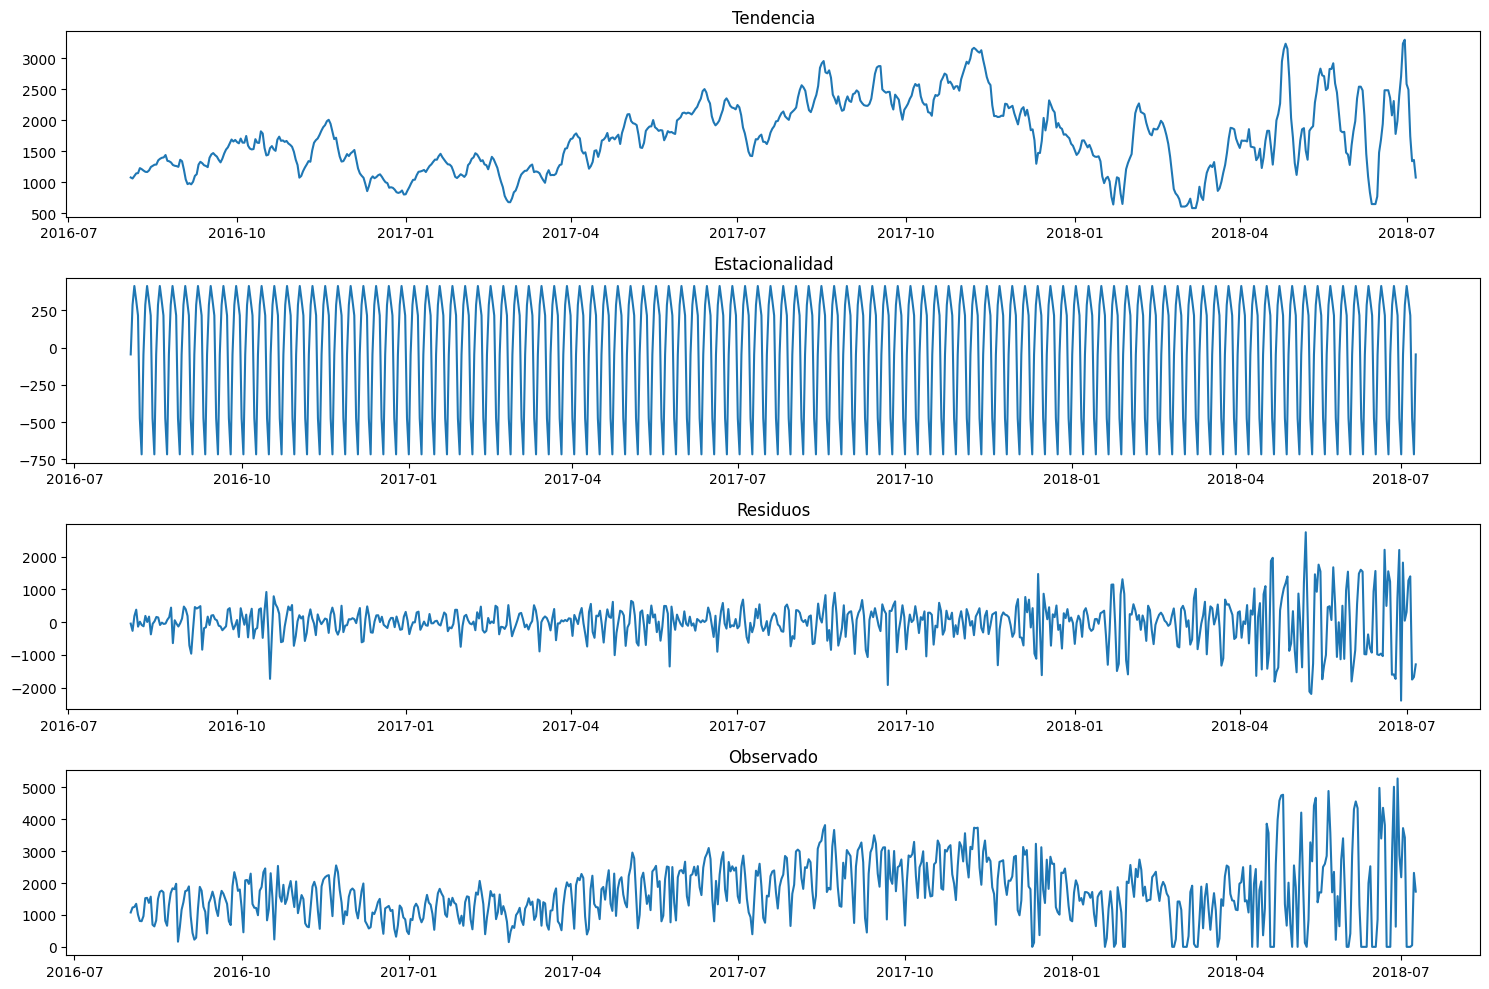

In [54]:
daily_result = seasonal_decompose(daily_rent, model='additive')

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(daily_result.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 2)
plt.plot(daily_result.seasonal)
plt.title('Estacionalidad')

plt.subplot(4, 1, 3)
plt.plot(daily_result.resid)
plt.title('Residuos')

plt.subplot(4, 1, 4)
plt.plot(daily_result.observed)
plt.title('Observado')

plt.tight_layout()
plt.show()

#### Análisis
* A partir de los gráficos podemos observary una tendencia alcista a partir de los meses de marzo y bajista a partir de diciembre. 
* Observamos una clara estacionalidad en la serie que coincide con lo visto en los gráficos intrasemanales e intradiarios.
* No parece haber ningún patrón en el residual (observado - (trend+seasonality))

#### Extraer la tendencia y ajustar un modelo determinístico:
Explicar su relación con el contexto. Obtener conclusiones acerca de la validez del modelo.


In [77]:
tendencia = daily_result.trend

tendencia = tendencia.dropna()

x_data = np.arange(len(tendencia))
y_data = tendencia

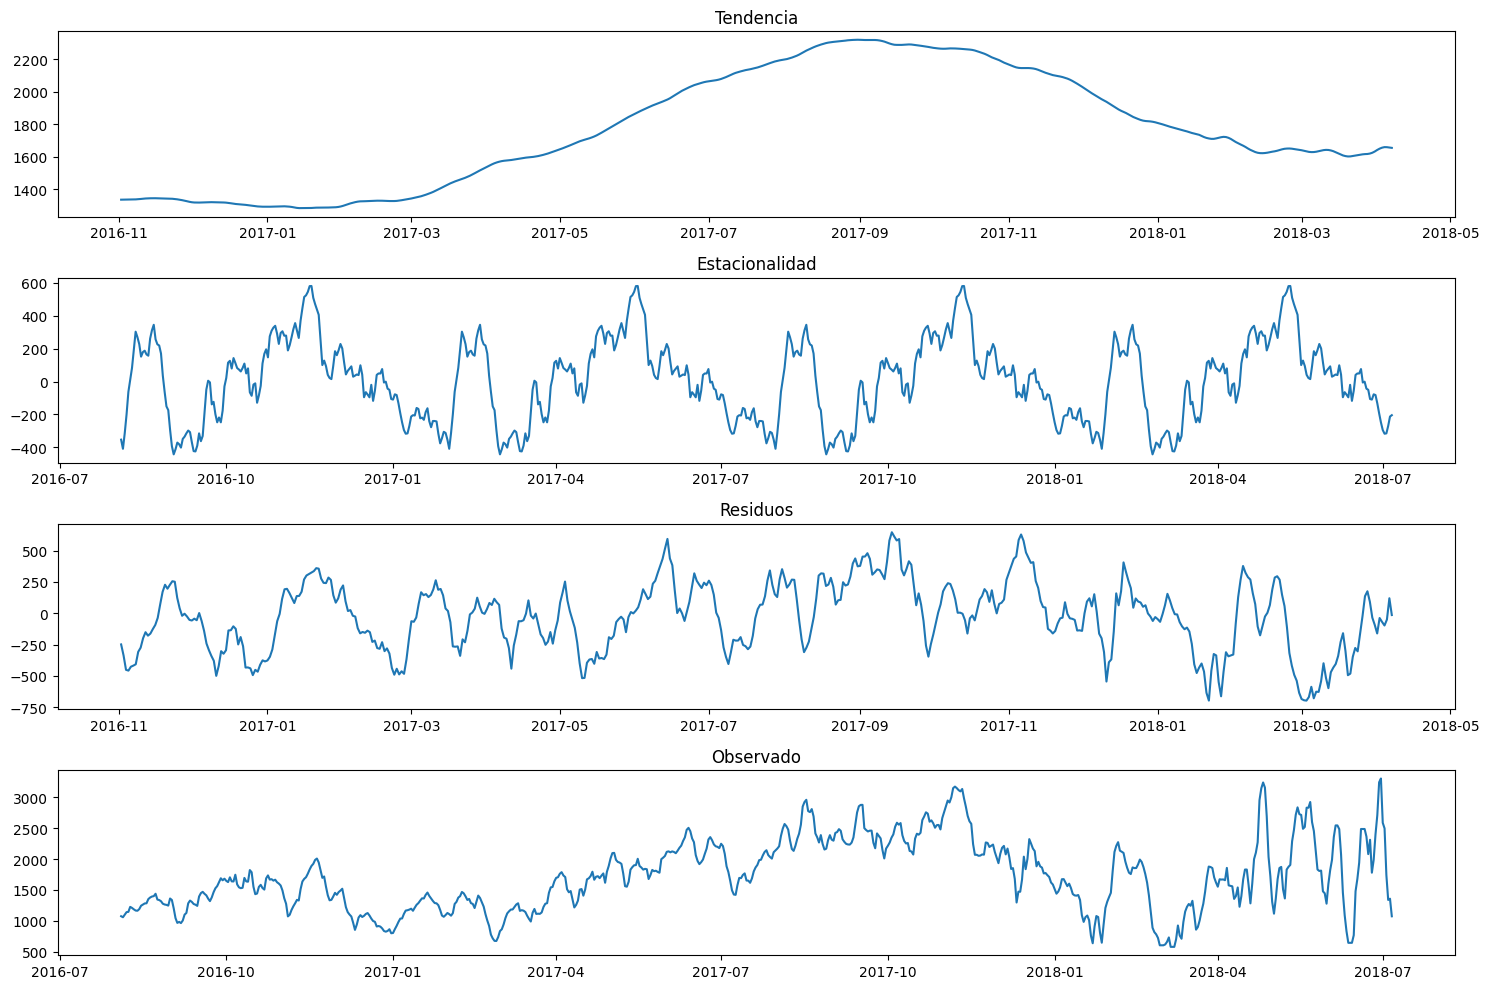

In [120]:
tend = seasonal_decompose(tendencia, model='additive', period=180)

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(tend.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 2)
plt.plot(tend.seasonal)
plt.title('Estacionalidad')

plt.subplot(4, 1, 3)
plt.plot(tend.resid)
plt.title('Residuos')

plt.subplot(4, 1, 4)
plt.plot(tend.observed)
plt.title('Observado')

plt.tight_layout()
plt.show()

In [80]:
def quadratic_model(x,a,b,c):
    return a*x**2 + b*x + c

In [87]:
def sinusoidal_model(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

In [97]:
def cosine_model(x, a, b, c, d):
    return a * np.cos(b * x + c) + d

# a = amplitud, b=frecuencia, c=fase, d=offset

In [133]:
def double_cosine_model(x, a, b, c, d, e, f, g):
    return a * np.cos(b * x + c) + d + e * np.cos(f * x + g)

# a = amplitud, b=frecuencia, c=fase, d=offset

In [143]:
#popt, pcov = curve_fit(quadratic_model, x_data, y_data)
#popt, pcov = curve_fit(sinusoidal_model, x_data, y_data, p0=(1, 2*np.pi/365, 0, np.mean(y_data)))
#popt, pcov = curve_fit(cosine_model, x_data, y_data,  p0=(0, 2*np.pi/365, 0, np.mean(y_data)))
popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=(2500, 2*np.pi/365, 0, np.mean(y_data), 1, 2*np.pi/365*7, 0))


In [179]:
np.random.random?

Docstring:
random(size=None)

Return random floats in the half-open interval [0.0, 1.0). Alias for
`random_sample` to ease forward-porting to the new random API.
Type:      builtin_function_or_method

In [192]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

best_rmse = None
best_sol = None

for i in range(1000):
    p0 = [np.random.randint(50, 5000), np.random.uniform(0.001, 0.5), np.random.random(), 
          np.random.randint(int(np.mean(y_data)/20),  int(np.mean(y_data)*20)), 
          np.random.randint(20, 1000), np.random.uniform(0.001, 0.75), np.random.random()]
    try:
        popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=p0)
    except:
        continue

    y_fit = double_cosine_model(x_data, *popt)
    this_rmse = rmse(y_data, y_fit)
    if best_rmse is None or this_rmse < best_rmse:
        best_rmse = this_rmse
        best_sol = popt
        print("found better ", best_rmse)
    

found better  568.7380376794588
found better  567.1881785040163
found better  471.41856337463156
found better  466.6463682011461
found better  465.0843395283887
found better  465.0843380970752
found better  422.7900467890883


In [ ]:
y_data

date
2016-08-04    1075.714286
2016-08-05    1059.285714
2016-08-06    1101.000000
2016-08-07    1141.857143
2016-08-08    1146.142857
                 ...     
2018-07-02    2495.428571
2018-07-03    1742.142857
2018-07-04    1339.000000
2018-07-05    1358.714286
2018-07-06    1074.571429
Freq: D, Name: trend, Length: 702, dtype: float64

In [310]:
double_cosine_model??

Signature: double_cosine_model(x, a, b, c, d, e, f, g)
Docstring: <no docstring>
Source:   
def double_cosine_model(x, a, b, c, d, e, f, g):
    return a * np.cos(b * x + c) + d + e * np.cos(f * x + g)
File:      /var/folders/30/4fg_jqmn6t5bqy5p8vdxjmpr0000gp/T/ipykernel_907/4223520778.py
Type:      function

In [315]:
p0

[1265,
 0.3268186389004386,
 0.4568214576060926,
 21222,
 338,
 0.05471697393179488,
 0.8393861171147776]

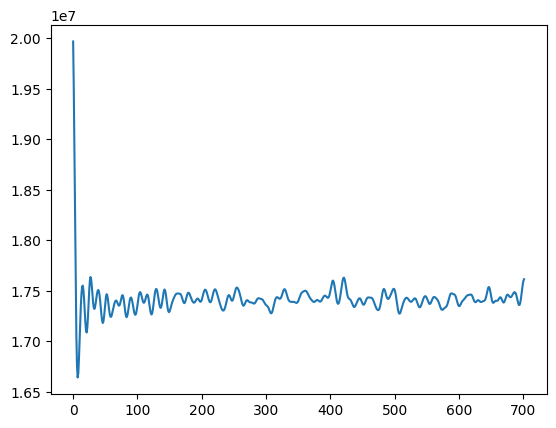

In [314]:
sols = []
for i in range(1000):
    p0 = [np.random.randint(50, 5000), np.random.uniform(0.001, 0.5), np.random.random(), 
          np.random.randint(int(np.mean(y_data)/20),  int(np.mean(y_data)*20)), 
          np.random.randint(20, 1000), np.random.uniform(0.001, 0.75), np.random.random()]

    y_fit = double_cosine_model(x_data, *p0)
    sols.append(y_fit)

plt.plot(sum(sols))
    

In [144]:
2*np.pi/365*24

0.41314095170495907

In [146]:
popt.tolist()


[107.05274826856622,
 -0.055145838563312705,
 -8.286235885145452,
 1722.4467047431967,
 -68.92545769890941,
 0.15178811682381205,
 5.443877868930841]

In [231]:
y_fit = double_cosine_model(x_data, *best_sol)


In [148]:
#y_fit = quadratic_model(x_data, a_opt, b_opt, c_opt)
#y_fit = sinusoidal_model(x_data, a_opt, b_opt, c_opt, d_opt)
#y_fit = cosine_model(x_data, a_opt, b_opt, c_opt, d_opt)

In [232]:
def double_cosine_model(x, a, b, c, d, e, f, g):
    return a * np.cos(b * x + c) + d + e * np.cos(f * x + g)


In [233]:
'''plt.figure(figsize=(10,5))
y_fit = double_cosine_model(x_data, 607.05274826856622,
 -0.055145838563312705,
 -8.286235885145452,
 1722.4467047431967,
 1200.92545769890941,
 0.0008178811682381205,

 2.443877868930841)

plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('doble coseno para modelar tendencia')  
plt.grid(True)'''

'plt.figure(figsize=(10,5))\ny_fit = double_cosine_model(x_data, 607.05274826856622,\n -0.055145838563312705,\n -8.286235885145452,\n 1722.4467047431967,\n 1200.92545769890941,\n 0.0008178811682381205,\n\n 2.443877868930841)\n\nplt.plot(x_data, y_data, \'b.\', label=\'original data\')\nplt.plot(x_data, y_fit, \'r.\', label="fitted data")\nplt.xlabel(\'time\')\nplt.ylabel(\'trend\')\nplt.title(\'doble coseno para modelar tendencia\')  \nplt.grid(True)'

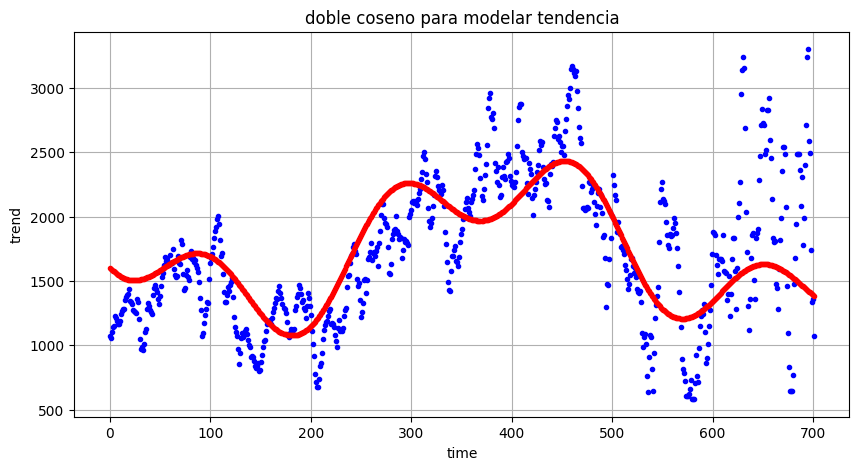

In [234]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('doble coseno para modelar tendencia')  
plt.grid(True)

In [ ]:
mask = (fft.real > 10e6)
print(mask.sum())
fft[mask] = 0 + 0j


In [276]:
a = np.percentile(np.absolute(fft), np.linspace(0, 100, num=10))[0]
((np.absolute(fft) > a) & (fft.real < 1e6)).sum()

700

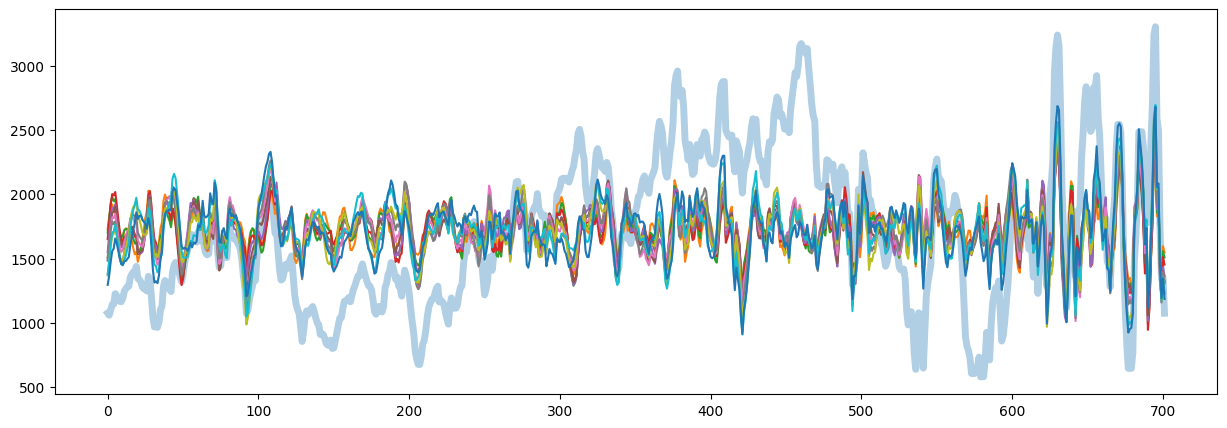

In [308]:
plt.figure(figsize=(15,5))
plt.plot(y_data.values, lw=5, alpha=0.35)
fft = np.fft.fft(y_data.values)
for threshold in np.percentile(np.absolute(fft), np.linspace(0, 100, num=1000)[900:950:5]):
    fft = np.fft.fft(y_data.values)

    mask = (np.absolute(fft) > threshold) & (fft.real < 1e6)
    fft[mask] = 0 + 0j

    plt.plot(np.fft.ifft(fft))


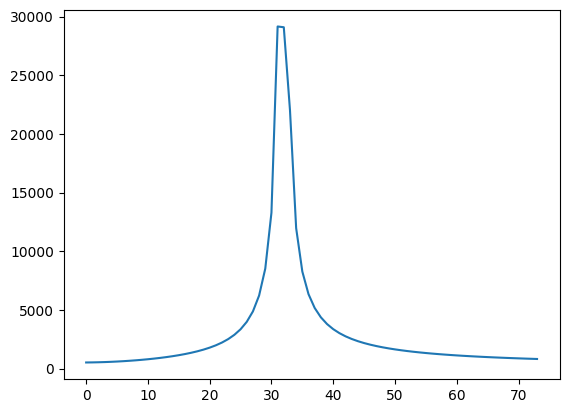

In [208]:
plt.plot(np.absolute(np.fft.fft(y_fit)[1:75]))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('doble coseno para modelar tendencia')  
plt.grid(True)

no pasa por la media  en todos los puntos

hay mucha varianza en el final de la serie

habria uqe probar con otra familia de modelos


* Entrega clase 4: Evaluar si la serie original es estacionaria. Aplicar transformaciones
(preprocesamiento), graficar autocorrelación, autocorrelación parcial y extraer conclusiones.

#### Evaluar si la serie es estacionaria


In [123]:
bicis_por_dia.resample('D').sum()


date
2016-08-01    1077
2016-08-02    1233
2016-08-03    1249
2016-08-04    1348
2016-08-05    1008
              ... 
2018-07-05       0
2018-07-06       0
2018-07-07      50
2018-07-08    2317
2018-07-09    1730
Freq: D, Name: bici_id_usuario, Length: 708, dtype: int64

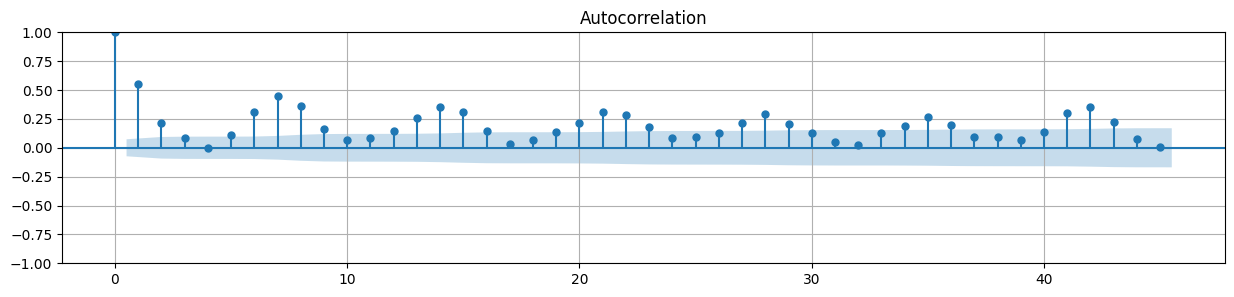

In [132]:
# calculo autocorrelación y autocorrelación parcial

plt.figure(figsize=(15,3))
plot_acf(bicis_por_dia.resample('D').sum(), lags=45, ax=plt.gca()) #lags=dias
plt.grid(True)
plt.show()


A partir de este gráfico de autocorrelación, podemos observar una clara autocorrelación intradiaria e intrasemanal, que coincide con lo observado en los gráficos más arriba, donde se ve la tendencia semanal (con más alquileres durante los días de semana) y por día (con tendencia alcista a partir de las 6 am y y bajista despues de las 11 de la noche). Se observan picos correspondientes a ciclos de 24 horas. 



In [ ]:
# autocorrelacion parcial

acf_values, conf_int = pacf(bicis_por_dia, alpha=0.05)

<Figure size 1200x600 with 0 Axes>

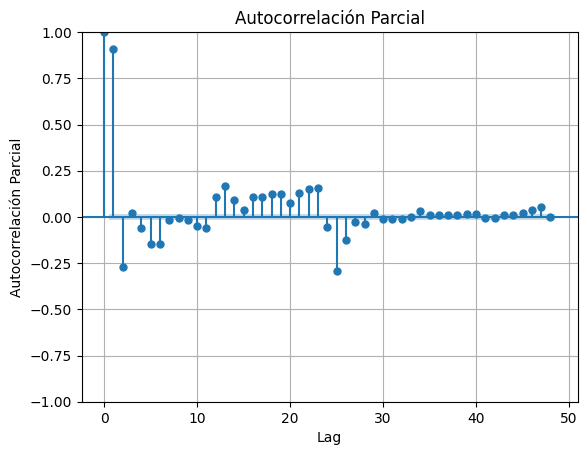

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12, 6))
plot_pacf(bicis_por_dia, lags=48, alpha=0.05)
plt.title('Autocorrelación Parcial')
plt.xlabel('Lag')   
plt.ylabel('Autocorrelación Parcial')
plt.grid(True)
plt.show()


A partir de este gráfico de autocorrelación parcial, observamos una autocorrelación fuerte cuando el lag = 1, esto nos sugiere que el valor de la serie de tiempo en una hora está muy influenciado por su valor en la hora anterior.
Pero a medida que nos movemos, las autocorrelaciones parciales tienden a ir disminuyendo y acercándose cada vez más a cero, lo que nos sugiere que la influencia del pasado o de las horas anteriores en la serie disminuye a medida que aumenta la distancia temporal.

In [ ]:
# aplico test de dickey fuller. Primero es necesario quitar trends, seasonality, diferenciasr

adf_result = adfuller(bicis_por_dia)
print('estadistica:', adf_result[0])
print('p valor:', adf_result[1])
print('valores criticos:', adf_result[2])

estadistica: -11.3292005016236
p valor: 1.1236442327391579e-20
valores criticos: 44


movimiento de hora
movimiento semanal
